In [2]:
#pip install lightgbm

In [3]:
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from functools import reduce
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from IPython.display import display
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt 
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import datetime

In [4]:
final5 = pd.read_csv('final5.csv') 

In [5]:
final5.columns

Index(['Date_x', 'location_x', 'location_ID', 'Precipitable_water_x', 'RH_x',
       'SH_x', 'Temp_x', 'U_wind_x', 'V_wind_x', 'NO2_column_x', 'NO2_slant_x',
       'NO2_strato_x', 'Pressure_x', 'NO2_trop_x', 'O3_x', 'CO_x', 'H2O_x',
       'Cloud_x', 'Aerosol_x', 'avg_vis_mean_x', 'cf_cvg_mean_x',
       'pop_density2010_mean_x', 'NDVI_8500_mean_x', 'QA_8500_mean_x',
       'elevation_500_mean_x', 'PM25_x', 'Human_modification_500_mean'],
      dtype='object')

In [8]:
final5 = final5[final5['PM25_x'] > 0]

In [11]:
#remove outliers based on the PM2.5 values (less than z-score = 3) # within 3 standard deviations from the mean
from scipy import stats
final5 = final5[(np.abs(stats.zscore(final5['PM25_x'])) < 3)]

<AxesSubplot:xlabel='location_ID', ylabel='PM25_x'>

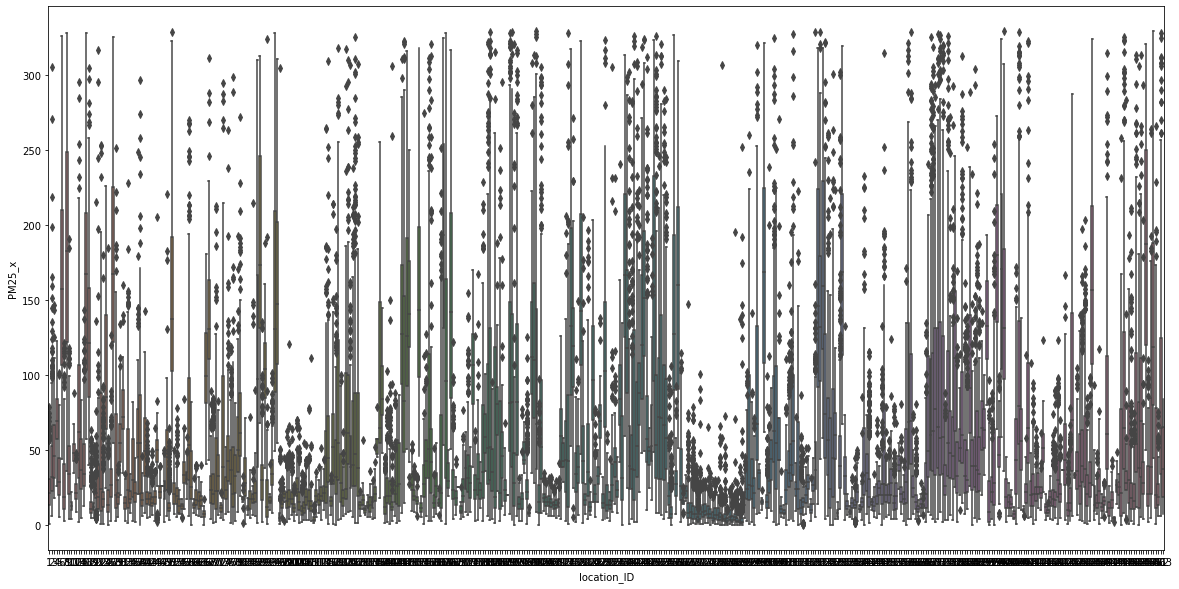

In [12]:
plt. figure(figsize=(20,10))
sns.boxplot(x="location_ID", y="PM25_x", data=final5)

In [13]:
final5.shape

(89152, 27)

<AxesSubplot:xlabel='location_ID', ylabel='NO2_trop_x'>

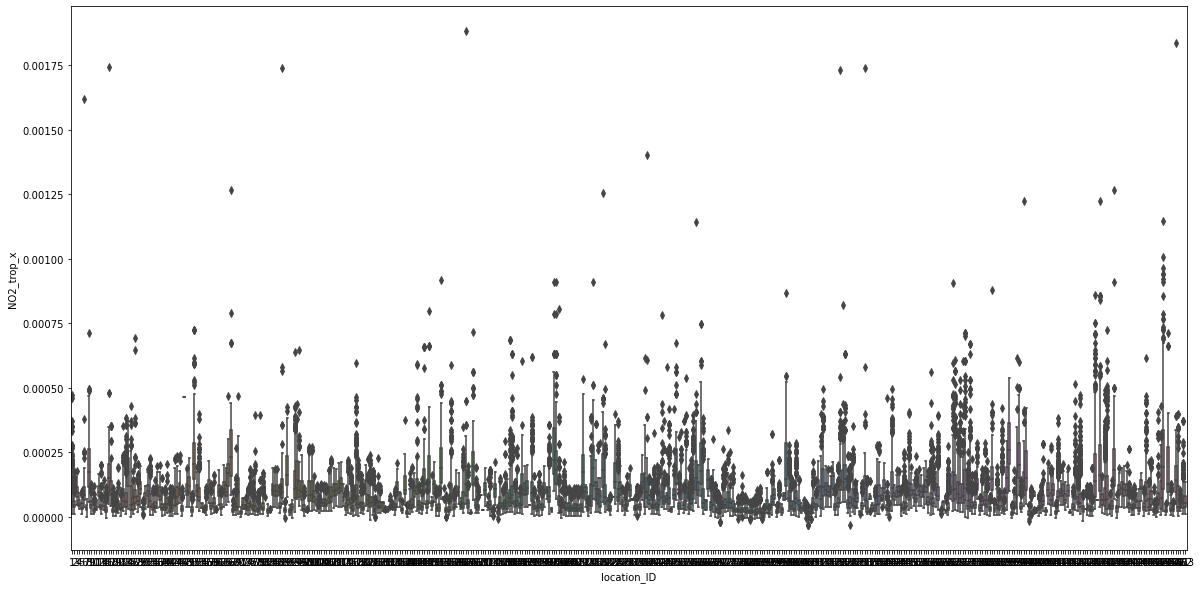

In [14]:
plt. figure(figsize=(20,10))
sns.boxplot(x="location_ID", y="NO2_trop_x", data=final5)

In [15]:
#remove outliers
final5 = final5[final5['NO2_trop_x'] < 0.001]

In [16]:
final5.columns

Index(['Date_x', 'location_x', 'location_ID', 'Precipitable_water_x', 'RH_x',
       'SH_x', 'Temp_x', 'U_wind_x', 'V_wind_x', 'NO2_column_x', 'NO2_slant_x',
       'NO2_strato_x', 'Pressure_x', 'NO2_trop_x', 'O3_x', 'CO_x', 'H2O_x',
       'Cloud_x', 'Aerosol_x', 'avg_vis_mean_x', 'cf_cvg_mean_x',
       'pop_density2010_mean_x', 'NDVI_8500_mean_x', 'QA_8500_mean_x',
       'elevation_500_mean_x', 'PM25_x', 'Human_modification_500_mean'],
      dtype='object')

In [17]:
final6 = final5.copy().drop(columns = ['Date_x','location_x', 'location_ID'], axis=1)

In [18]:
final6 = final6.rename(columns={'Date_x': "Date", 'location_x':"location", 'Precipitable_water_x':"Precipitable_water",
                                'RH_x':"RH",'SH_x':"SH", 'Temp_x':"Temp", 'U_wind_x':"U_wind", 'V_wind_x':"V_wind",
                                'NO2_column_x':"NO2_column", 'NO2_slant_x':"NO2_slant",
       'NO2_strato_x':"NO2_strato", 'Pressure_x':"Pressure", 'NO2_trop_x':"NO2_trop", 'O3_x':"O3", 'CO_x':"CO", 'H2O_x':"H2O",
       'Cloud_x':"Cloud", 'Aerosol_x':"Aerosol", 'avg_vis_mean_x':"Avg", 'cf_cvg_mean_x':"Cf_cvg",
       'pop_density2010_mean_x':"Pop_density", 'NDVI_8500_mean_x':"NDVI", 'QA_8500_mean_x':"QA",
       'elevation_500_mean_x':"Elevation", 'PM25_x':"PM25", 'Human_modification_500_mean':"Human"})

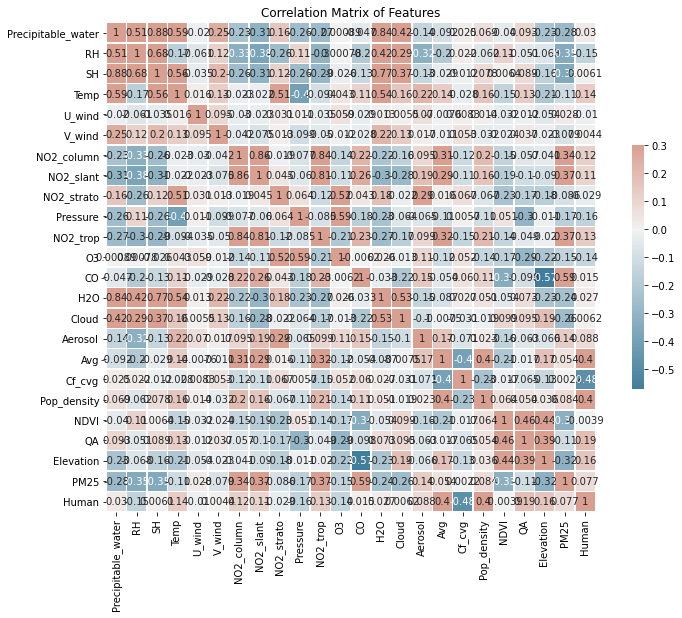

In [19]:
#create a correlation matrix

corr = final6.corr()
#mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap = cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)
plt.title('Correlation Matrix of Features');
plt.savefig('Correlation Matrix of Features.png',bbox_inches = 'tight')

#annot=True

In [20]:
# drop columns because of multicolinearily

final7 = final6.drop(columns = ['H2O', 'Precipitable_water','RH', 'NO2_column', 'NO2_slant'], axis=1)

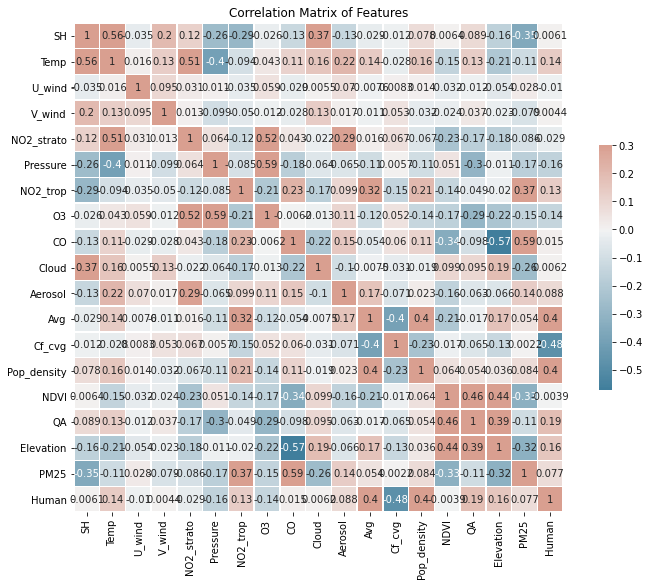

In [21]:
corr = final7.corr()
#mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap = cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)
plt.title('Correlation Matrix of Features');
plt.savefig('Correlation Matrix of Features.png',bbox_inches = 'tight')

#annot=True

In [22]:
final8 = final7.copy().dropna()
final8.columns

Index(['SH', 'Temp', 'U_wind', 'V_wind', 'NO2_strato', 'Pressure', 'NO2_trop',
       'O3', 'CO', 'Cloud', 'Aerosol', 'Avg', 'Cf_cvg', 'Pop_density', 'NDVI',
       'QA', 'Elevation', 'PM25', 'Human'],
      dtype='object')

In [23]:
frame = final8.copy()

In [24]:
y = frame.pop('PM25').to_frame()
X = frame

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [26]:
X_train.shape

(56682, 18)

In [27]:
X_test.shape

(14171, 18)

## LinearRegression

In [28]:
pipe_lin = Pipeline([
        ('scale', StandardScaler()), ('lin', LinearRegression())])

pipe_lin.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()), ('lin', LinearRegression())])

In [29]:
print('Score on train data: {}\n'.format(pipe_lin.score(X_train,y_train)))

Score on train data: 0.5159187605927351



In [30]:
print(cross_val_score(pipe_lin, X_train, y_train, cv=5))

[0.5319639  0.5171933  0.5141468  0.5140854  0.50002083]


In [31]:
np.mean((cross_val_score(pipe_lin, X_train, y_train, cv=5)))

0.5154820458785652

## DecisionTreeRegressor

In [32]:
pipe_tree = Pipeline([
        ('scale', StandardScaler()), ('tree', DecisionTreeRegressor())])

#hypterparameter tuning
grid_params = {'tree__max_depth':[3,4,5,6,7],
               'tree__max_features':['auto','sqrt','log2'],
         'tree__min_samples_split':[2,3,4,5,6,7,8,9,10],
         'tree__min_samples_leaf':[2,3,4,5,6,7,8,9,10]}   
     
tree_search = GridSearchCV(pipe_tree, grid_params, verbose=1, cv=5, n_jobs=-1)

In [33]:
pipe_tree.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scale', 'tree', 'scale__copy', 'scale__with_mean', 'scale__with_std', 'tree__ccp_alpha', 'tree__criterion', 'tree__max_depth', 'tree__max_features', 'tree__max_leaf_nodes', 'tree__min_impurity_decrease', 'tree__min_impurity_split', 'tree__min_samples_leaf', 'tree__min_samples_split', 'tree__min_weight_fraction_leaf', 'tree__presort', 'tree__random_state', 'tree__splitter'])

In [35]:
tree_search.fit(X_train, y_train)

Fitting 5 folds for each of 1215 candidates, totalling 6075 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 6075 out of 6075 | elapsed:  4.1min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('tree', DecisionTreeRegressor())]),
             n_jobs=-1,
             param_grid={'tree__max_depth': [3, 4, 5, 6, 7],
                         'tree__max_features': ['auto', 'sqrt', 'log2'],
                         'tree__min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'tree__min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9,
                                                     10]},
             verbose=1)

In [36]:
print('Best parameters found:')
display(tree_search.best_params_)

Best parameters found:


{'tree__max_depth': 7,
 'tree__max_features': 'auto',
 'tree__min_samples_leaf': 10,
 'tree__min_samples_split': 2}

In [37]:
print('Score on train data: {}\n'.format(tree_search.score(X_train,y_train)))

Score on train data: 0.6791994652860791



In [38]:
print('best cv score:')
display(tree_search.best_score_)

print('mean cv score:')
display(np.mean(tree_search.cv_results_["mean_test_score"]))

best cv score:


0.6620209210706003

mean cv score:


0.5449010293249525

## RandomForestRegressor

In [39]:
pipe_forest = Pipeline([
        ('scale', StandardScaler()), ('forest', RandomForestRegressor())])
pipe_forest.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scale', 'forest', 'scale__copy', 'scale__with_mean', 'scale__with_std', 'forest__bootstrap', 'forest__ccp_alpha', 'forest__criterion', 'forest__max_depth', 'forest__max_features', 'forest__max_leaf_nodes', 'forest__max_samples', 'forest__min_impurity_decrease', 'forest__min_impurity_split', 'forest__min_samples_leaf', 'forest__min_samples_split', 'forest__min_weight_fraction_leaf', 'forest__n_estimators', 'forest__n_jobs', 'forest__oob_score', 'forest__random_state', 'forest__verbose', 'forest__warm_start'])

In [40]:
# Hypterparameter tuning was conducted using GridSearchCV
# The below parametrs were determined based on the results obtained from GridSearchCV
params = {'forest__n_estimators':[600]}

forest_search = GridSearchCV(pipe_forest,params,n_jobs=-1, cv=5,verbose=2)
forest_search.fit(X_train,y_train.values.ravel())


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  7.7min remaining: 11.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('forest', RandomForestRegressor())]),
             n_jobs=-1, param_grid={'forest__n_estimators': [600]}, verbose=2)

In [41]:
print('Score on train data: {}\n'.format(forest_search.score(X_train, y_train.values.ravel())))
print('Best parameters found:')
display(forest_search.best_params_)

Score on train data: 0.9747153404130166

Best parameters found:


{'forest__n_estimators': 600}

In [42]:
print('best cv score:')
display(forest_search.best_score_)

print('mean cv score:')
display(np.mean(forest_search.cv_results_["mean_test_score"]))

best cv score:


0.8059117270138794

mean cv score:


0.8059117270138794

In [43]:
forest_best_estim = forest_search.best_estimator_
print(forest_best_estim)

Pipeline(steps=[('scale', StandardScaler()),
                ('forest', RandomForestRegressor(n_estimators=600))])


In [44]:
forest_best_estim.fit(X_train, y_train)

forest_ytrain_pred = forest_best_estim.predict(X_train)
forest_rmse = np.sqrt(mean_squared_error(forest_ytrain_pred,  y_train.values.ravel()))
forest_r2 = r2_score(forest_ytrain_pred,y_train.values.ravel())
print("RMSE: %.2f" % forest_rmse)
print("R2: %.2f" % forest_r2)

C:\Users\ayako\anaconda3\lib\site-packages\sklearn\pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


RMSE: 8.26
R2: 0.97


## GradientBoostingRegressor

In [45]:
pipe_gboost = Pipeline([
        ('scale', StandardScaler()), ('gboost', GradientBoostingRegressor())])
pipe_gboost.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scale', 'gboost', 'scale__copy', 'scale__with_mean', 'scale__with_std', 'gboost__alpha', 'gboost__ccp_alpha', 'gboost__criterion', 'gboost__init', 'gboost__learning_rate', 'gboost__loss', 'gboost__max_depth', 'gboost__max_features', 'gboost__max_leaf_nodes', 'gboost__min_impurity_decrease', 'gboost__min_impurity_split', 'gboost__min_samples_leaf', 'gboost__min_samples_split', 'gboost__min_weight_fraction_leaf', 'gboost__n_estimators', 'gboost__n_iter_no_change', 'gboost__presort', 'gboost__random_state', 'gboost__subsample', 'gboost__tol', 'gboost__validation_fraction', 'gboost__verbose', 'gboost__warm_start'])

In [46]:
# Hypterparameter tuning was conducted using GridSearchCV
# The below parametrs were determined based on the results obtained from GridSearchCV
params = {'gboost__learning_rate':[0.1],
         'gboost__max_depth':[10]}
gboost_search = GridSearchCV(pipe_gboost,params,n_jobs=-1,cv=5,verbose=2)
gboost_search.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
C:\Users\ayako\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('gboost',
                                        GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid={'gboost__learning_rate': [0.1],
                         'gboost__max_depth': [10]},
             verbose=2)

In [47]:
print('Score on train data: {}\n'.format(gboost_search.score(X_train,y_train)))
print('Best parameters found:')
display(gboost_search.best_params_)

Score on train data: 0.9534569095954988

Best parameters found:


{'gboost__learning_rate': 0.1, 'gboost__max_depth': 10}

In [48]:
print('best cv score:')
display(np.mean(gboost_search.best_score_))

print('mean cv score:')
display(np.mean(gboost_search.cv_results_["mean_test_score"]))

best cv score:


0.8084918260821722

mean cv score:


0.8084918260821722

In [49]:
gboost_best_estim = gboost_search.best_estimator_
print(gboost_best_estim)

Pipeline(steps=[('scale', StandardScaler()),
                ('gboost', GradientBoostingRegressor(max_depth=10))])


In [50]:
gboost_best_estim.fit(X_train, y_train)

gboost_ytrain_pred = gboost_best_estim.predict(X_train)
gboost_rmse = np.sqrt(mean_squared_error(gboost_ytrain_pred, y_train.values.ravel()))
gboost_r2 = r2_score(gboost_ytrain_pred,y_train.values.ravel())
print("RMSE: %.2f" % gboost_rmse)
print("R2: %.2f" % gboost_r2)

C:\Users\ayako\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


RMSE: 11.19
R2: 0.95


## XGBRegressor

In [51]:
pipe_xgb = Pipeline([
        ('scale', StandardScaler()), ('xgb', XGBRegressor(objective='reg:squarederror'))])
pipe_xgb.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scale', 'xgb', 'scale__copy', 'scale__with_mean', 'scale__with_std', 'xgb__objective', 'xgb__base_score', 'xgb__booster', 'xgb__colsample_bylevel', 'xgb__colsample_bynode', 'xgb__colsample_bytree', 'xgb__gamma', 'xgb__gpu_id', 'xgb__importance_type', 'xgb__interaction_constraints', 'xgb__learning_rate', 'xgb__max_delta_step', 'xgb__max_depth', 'xgb__min_child_weight', 'xgb__missing', 'xgb__monotone_constraints', 'xgb__n_estimators', 'xgb__n_jobs', 'xgb__num_parallel_tree', 'xgb__random_state', 'xgb__reg_alpha', 'xgb__reg_lambda', 'xgb__scale_pos_weight', 'xgb__subsample', 'xgb__tree_method', 'xgb__validate_parameters', 'xgb__verbosity'])

In [52]:
# Hypterparameter tuning was conducted using GridSearchCV
# The below parametrs were determined based on the results obtained from GridSearchCV
params = {'xgb__learning_rate':[0.1],
         'xgb__max_depth': [11],
          'xgb__n_estimators':[1400],
         'xgb__reg_lambda': [1000]}
xgb_search = GridSearchCV(pipe_xgb,params,n_jobs=-1,cv=5,verbose=2)
xgb_search.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.9min remaining:  5.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('xgb',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     gamma=None, gpu_id=None,
                                                     importance_type='gain',
                                                     interaction_constraints=None,
                                                     learning_rate=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                              

In [53]:
print('Score on train data: {}\n'.format(xgb_search.score(X_train,y_train)))
print('Best parameters found:')
display(xgb_search.best_params_)

Score on train data: 0.9532940752011263

Best parameters found:


{'xgb__learning_rate': 0.1,
 'xgb__max_depth': 11,
 'xgb__n_estimators': 1400,
 'xgb__reg_lambda': 1000}

In [54]:
print('best cv score:')
display(xgb_search.best_score_)

print('mean cv score:')
display(np.mean(xgb_search.cv_results_["mean_test_score"]))

best cv score:


0.8266262795805714

mean cv score:


0.8266262795805714

In [55]:
xgb_best_estim = xgb_search.best_estimator_
print(xgb_best_estim)

Pipeline(steps=[('scale', StandardScaler()),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=11,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=1400,
                              n_jobs=8, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1000, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])


In [56]:
xgb_best_estim.fit(X_train, y_train)

xgb_ytrain_pred = xgb_best_estim.predict(X_train)
xgb_rmse = np.sqrt(mean_squared_error(xgb_ytrain_pred, y_train))
xgb_r2 = r2_score(xgb_ytrain_pred,y_train)
print("RMSE: %.2f" % xgb_rmse)
print("R2: %.2f" % xgb_r2)

RMSE: 11.21
R2: 0.95


## LightGBMRegressor

In [57]:
pipe_LGBM = Pipeline([
        ('scale', StandardScaler()), ('LGBM', LGBMRegressor())])
pipe_LGBM.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scale', 'LGBM', 'scale__copy', 'scale__with_mean', 'scale__with_std', 'LGBM__boosting_type', 'LGBM__class_weight', 'LGBM__colsample_bytree', 'LGBM__importance_type', 'LGBM__learning_rate', 'LGBM__max_depth', 'LGBM__min_child_samples', 'LGBM__min_child_weight', 'LGBM__min_split_gain', 'LGBM__n_estimators', 'LGBM__n_jobs', 'LGBM__num_leaves', 'LGBM__objective', 'LGBM__random_state', 'LGBM__reg_alpha', 'LGBM__reg_lambda', 'LGBM__silent', 'LGBM__subsample', 'LGBM__subsample_for_bin', 'LGBM__subsample_freq'])

In [58]:
# Hypterparameter tuning was conducted using GridSearchCV
# Parametrs were determined based on the results obtained from GridSearchCV
params = {'LGBM__max_depth': [20],
          'LGBM__learning_rate':[0.1],
          'LGBM__num_leaves':[400],
          'LGBM__reg_lambda':[500],
          'LGBM__n_estimators': [800]
         }
LGBM_search = GridSearchCV(pipe_LGBM,params,n_jobs=-1,cv=5,verbose=2)
LGBM_search.fit(X_train,y_train.values.ravel())

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   31.6s remaining:   47.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.9s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('LGBM', LGBMRegressor())]),
             n_jobs=-1,
             param_grid={'LGBM__learning_rate': [0.1], 'LGBM__max_depth': [20],
                         'LGBM__n_estimators': [800], 'LGBM__num_leaves': [400],
                         'LGBM__reg_lambda': [500]},
             verbose=2)

In [59]:
print('Score on train data: {}\n'.format(LGBM_search.score(X_train,y_train.values.ravel())))
print('Best parameters found:')
display(LGBM_search.best_params_)

Score on train data: 0.9720993975332947

Best parameters found:


{'LGBM__learning_rate': 0.1,
 'LGBM__max_depth': 20,
 'LGBM__n_estimators': 800,
 'LGBM__num_leaves': 400,
 'LGBM__reg_lambda': 500}

In [60]:
print('best cv score:')
display(LGBM_search.best_score_)

print('mean cv score:')
display(np.mean(LGBM_search.cv_results_["mean_test_score"]))

best cv score:


0.8292465479168861

mean cv score:


0.8292465479168861

In [61]:
LGBM_best_estim = LGBM_search.best_estimator_
print(LGBM_best_estim)

Pipeline(steps=[('scale', StandardScaler()),
                ('LGBM',
                 LGBMRegressor(max_depth=20, n_estimators=800, num_leaves=400,
                               reg_lambda=500))])


In [63]:
LGBM_best_estim.fit(X_train, y_train)

LGBM_ytrain_pred = LGBM_best_estim.predict(X_train)
LGBM_rmse = np.sqrt(mean_squared_error(LGBM_ytrain_pred, y_train))
LGBM_r2 = r2_score(LGBM_ytrain_pred,y_train)
print("RMSE: %.2f" % LGBM_rmse)
print("R2: %.2f" % LGBM_r2)

C:\Users\ayako\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


RMSE: 8.67
R2: 0.97


In [64]:
LGBM_ypred = LGBM_best_estim.predict(X_test)
LGBM_test_rmse = np.sqrt(mean_squared_error(y_test, LGBM_ypred))
LGBM_test_r2 = r2_score(y_test, LGBM_ypred)
print("RMSE: %.2f" % LGBM_test_rmse)
print("R2: %.2f" % LGBM_test_r2)

RMSE: 20.57
R2: 0.84


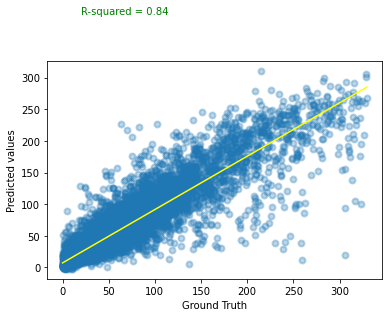

In [65]:
score = 0.84
x = np.array(y_test).flatten()
y = LGBM_ypred
plt.scatter(x = x, y = y, lw = 2, alpha = 0.3)
plt.xlabel('Ground Truth')
plt.ylabel('Predicted values')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = 'yellow')
plt.text(20,400, 'R-squared = %0.2f' % score, color = 'green')
plt.show()

In [66]:
ypred_df = pd.DataFrame({"prediction": LGBM_ypred})
pred_df = pd.DataFrame(y_test)
pred_df['prediction'] = ypred_df['prediction'].values
pred_df

,PM25,prediction
58075,43.708889,54.833151
54499,26.109000,70.827846
62453,215.100000,194.814387
13145,63.289222,65.487912
68214,136.500000,114.769102
...,...,...
10454,14.087500,11.874047
93344,151.750000,183.141223
75571,102.829167,104.119250
42508,26.603226,27.452365


In [67]:
final_merged = final5.merge(pred_df, how='outer', left_index=True, right_index=True)

Text(0, 0.5, 'PM2.5')

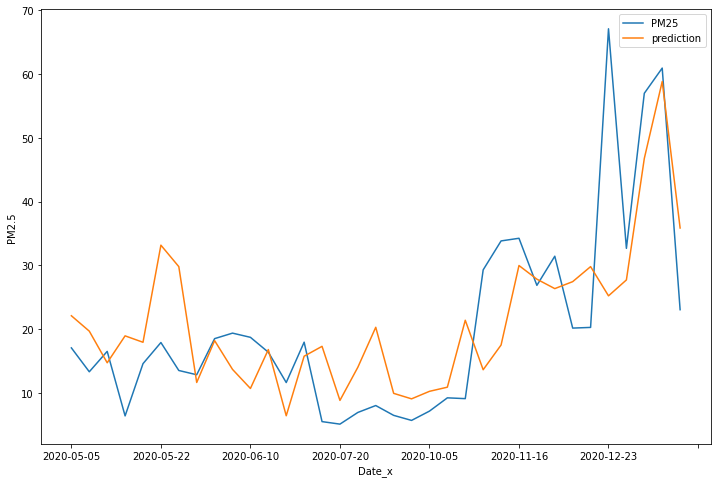

In [68]:
# plot results for US Diplomatic Post: Conakry (Guinea) location_ID: 425

guinea = final_merged.loc[final_merged['location_ID']==425]
guinea = guinea.copy().dropna(subset=['prediction'])
ax = guinea.plot(y='PM25', x='Date_x', figsize=(12, 8))
guinea.plot(y='prediction', ax=ax, x='Date_x')
plt.ylabel("PM2.5")

Text(0, 0.5, 'PM2.5')

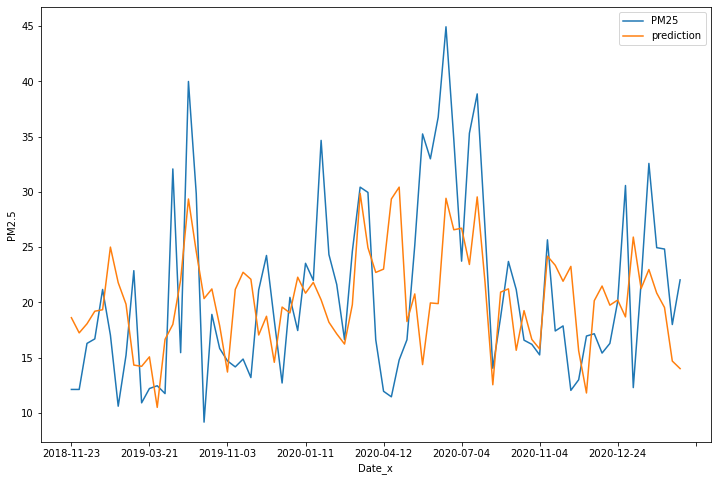

In [70]:
# plot results for Ethiopia location_ID: 421
ET = final_merged.loc[final_merged['location_ID']==421]
ET = ET.copy().dropna(subset=['prediction'])
ax = ET.plot(y='PM25', x='Date_x', figsize=(12, 8))
ET.plot(y='prediction', ax=ax, x='Date_x')
plt.ylabel("PM2.5")

Text(0, 0.5, 'PM2.5')

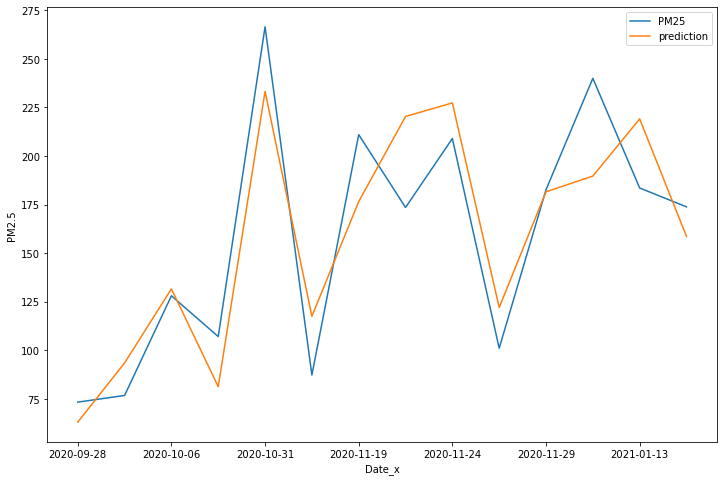

In [71]:
# plot results for India location_ID: 6
IN = final_merged.loc[final_merged['location_ID']==6]
IN = IN.copy().dropna(subset=['prediction'])
ax = IN.plot(y='PM25', x='Date_x', figsize=(12, 8))
IN.plot(y='prediction', ax=ax, x='Date_x')
plt.ylabel("PM2.5")